In [1]:
# basics
import numpy as np
import scipy.special as sp
import os

# dynesty
import dynesty
from dynesty import plotting as dyplot

# plotting
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

# seed the random number generator
rstate = np.random.default_rng(5647)

In [2]:
def force_func(gam, D, alpha, x):
    """ general expression for TSA force. """
    eps = 0.05
    if(alpha>(-1+eps) ):
        y = - (2*x**(1 + alpha) *gam)/(D*(1 + alpha))           
        denom = x*sp.hyp1f1(1,1 + 1/(1 + alpha) , y)
        force = D / denom - gam*x**alpha
    elif(alpha< (-1 -eps) ):
        y = - (2*x**(1 + alpha) *gam)/(D*(1 + alpha))
        denom = x*sp.hyperu(1,1 + 1/(1 + alpha) , y)
        force = - D*(alpha+1) /denom - gam*x**alpha
    else:
        force = - alpha*D/x + gam*x**alpha
    return force 

def force_func_beta(gam, D, alpha, beta, x):
    """ general expression for TSA force including beta. """
    """same as without beta but according to trafo f_beta = x**beta * f_alpha(L, alpha-beta), see SI"""
    alphaminusbeta = alpha-beta
    eps = 0.05
    if(alphaminusbeta > (-1+eps) ):
        y = - (2*x**(1 + alphaminusbeta) *gam)/(D*(1 + alphaminusbeta))           
        denom = x*sp.hyp1f1(1,1 + 1/(1 + alphaminusbeta) , y)
        force = D / denom - gam*x**alphaminusbeta
    elif(alphaminusbeta < (-1 -eps) ):
        y = - (2*x**(1 + alphaminusbeta) *gam)/(D*(1 + alphaminusbeta))
        denom = x*sp.hyperu(1,1 + 1/(1 + alphaminusbeta) , y)
        force = - D*(alphaminusbeta+1) /denom - gam*x**alphaminusbeta
    else:
        force = - alphaminusbeta*D/x + gam*x**alphaminusbeta
    return force * x**beta

def RW_force(D, x):
    """ TSA force for RW process (alpha = egal, gamma =0) """
    force = D/x
    return force

def RW_force_beta(D, beta, x):
    """ TSA force for RW process (alpha = egal, gamma =0) """
    force = D * x**(beta-1)
    return force

def bessel_force(gam, D, x):
    """ TSA force for bessel process (alpha = -1) """
    force = (D+gam)/x
    return force

def OU_force(gam, D, x):
    """ TSA force for Ornstein-Uhlenbeck process (alpha = 1) """
    force = -gam*x + np.sqrt(gam*D)/sp.dawsn(x * np.sqrt(gam/D))
    return force

def drift_force(gam, D, x):
    """ TSA force for advection process (alpha = 0) """
    expon = np.exp(-(2*gam*x)/D )
    nl_fac = (2*gam ) /(1.0- expon) 
    force = -gam + nl_fac
    return force

def neg_two_force(gam, D, x):
    """ TSA force for alpha = -2 """
    y = 2*gam/(D*x)
    force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
    
    # for numerical stability treat values y>100 separately
    if np.any(y>100):
        mask = np.where(y>100)
        force[mask] = D/x[mask] + gam /x[mask]**2
    return force

def force_discrete(gamma, D, alpha, x):
    """ specifiying which force function is used for given alpha """
    if alpha == 1.0:
        force = OU_force(gamma, D, x)
        return force
    elif alpha == 0.0:
        force = drift_force(gamma, D, x)
        return force
    elif alpha == -1.0:
        force = bessel_force(gamma, D, x)
        return force
    elif alpha == -2.0:
        force = neg_two_force(gamma, D, x)
        return force
    else:
        print('alpha value is not within the set of values used in the cytokinesis example.')

# Evidence Phasetransition: RW vs full model results

Using our path inference framework, we calculated evidences of the general 'free-$\gamma$' model and the RW model with $\gamma=0$. The difference in log-evidence is plotted in model space "$\alpha$-$\beta$".

### plotting cluster results

In [4]:
phdg_gamalp = np.loadtxt("phdg_gamalp.csv", delimiter=',')
phdg_betalp = np.loadtxt("phdg_betalp.csv", delimiter=',')

alpha_ar = [-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5 ,-0.4, -0.3 ,-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma_ar = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]#[1]#[0.03, 0.31, 2.16]
D_ar = [0.2]
beta_ar = [-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5 ,-0.4, -0.3 ,-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]#[0.5]

gamma dependency of evidence

C:\Users\nn\AppData\Local\Temp\ipykernel_20676\4098794276.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')


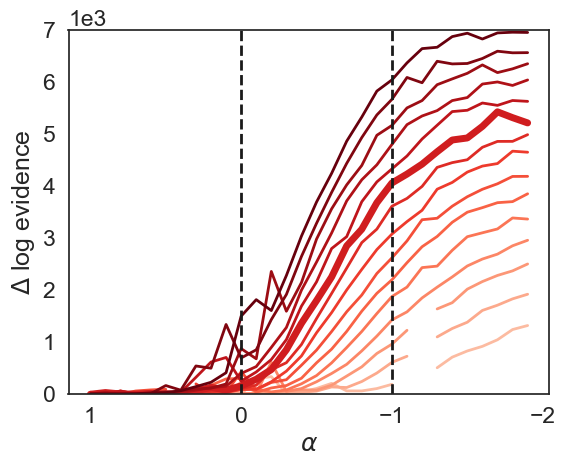

In [5]:
eqdist = 1
gam_ar = np.copy(gamma_ar[::eqdist])

cmap = plt.cm.get_cmap('Reds')
num_lines = 16
line_colors = np.linspace(0.2, 1, num_lines)
rgb_colors_BL = cmap(line_colors)

fig = plt.figure(figsize=(6,5))

for i in np.arange(len(gam_ar)):
    gamma = gam_ar[i]
    if gamma > 1.55 or gamma<0.1:
        continue
        
    #plt.plot(alpha_ar[1:], np.log(phdg_gamalp[i,1:]), label=gamma)
    if gamma == 1:
        plt.plot(alpha_ar[1:], phdg_gamalp[i*eqdist,1:], c=rgb_colors_BL[i], label=r'$\gamma =${}'.format(gamma), linewidth=5)
    else:
        plt.plot(alpha_ar[1:], phdg_gamalp[i*eqdist,1:], c=rgb_colors_BL[i], label=r'$\gamma =${}'.format(gamma))


        
plt.vlines(0, 0,7000,linestyle='--', color='k')
plt.vlines(-1, 0,7000,linestyle='--', color='k')

plt.gca().invert_xaxis()

plt.ylabel(r'$\Delta$ log evidence')
plt.xlabel(r'$\alpha$')
plt.ylim(ymin=0, ymax=7000)

#plt.legend(prop={"size": 10})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
#plt.savefig('phasediagram_gamma_inference_wolegend.pdf')
plt.show()

full $\alpha - \beta$ evidence phase diagram

C:\Users\nn\AppData\Local\Temp\ipykernel_20676\848810146.py:36: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


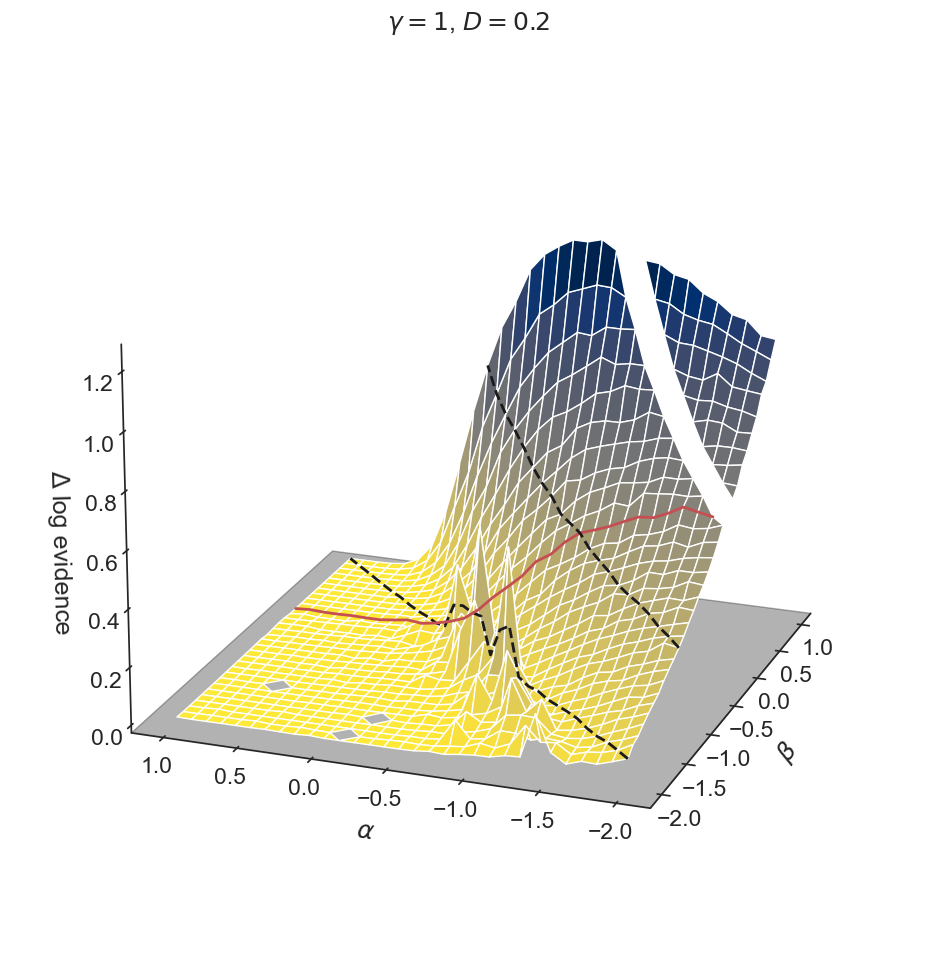

In [6]:
bets = beta_ar[:]
alps = alpha_ar[:]

Y,X = np.meshgrid(bets[:], alps[:])

ph = np.copy(phdg_betalp[:,:])
Z = ph[:,:]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z,  cmap = 'cividis_r')


ax.plot(beta_ar, alpha_ar, zs=np.diagonal(Z), linestyle='--', c='k', alpha=1)
ax.plot(np.zeros(len(alpha_ar)), alpha_ar,  Z[20,:], c='r', alpha=1)


secondbound= np.diagonal(Z, offset=-10)
ax.plot(beta_ar[10:], np.array(alpha_ar[10:])-1, zs=secondbound, linestyle='--' , c='k', alpha=1)



ax.set_xlabel(r'$\beta$', labelpad=15)
ax.set_ylabel(r'$\alpha$', labelpad=15)
ax.set_zlabel(r'$\Delta$ log evidence', rotation=90, labelpad=10)#

ax.view_init(20,200)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.3))

plt.ticklabel_format(style='sci', axis='z', scilimits=(0,0))

ax.dist = 11

plt.title(r'$\gamma=1$, $D=0.2$')
plt.tight_layout()

#plt.savefig('phasediagram_3dinference.pdf')

plt.show()

# CV phasendiagramm

theory functions

In [4]:
def mean_tsa_sn_mult(t,gam,d,alpha,beta):
    if alpha <0:
        frac1 = (t*(1 - alpha)*gam)**(1/(1 - alpha))
        nom2 = d*(7*alpha**2 + 2*beta*(1 + beta) - alpha*(3 + 8*beta))*(-t*(-1 + alpha)*gam)**((alpha - beta)/(-1 + alpha))
        denom2 = 2*(2*alpha - beta)*(-1 + 3*alpha - beta)*gam
        frac2 = nom2/denom2
        out = frac1 + frac2
    else:
        out = np.ones(len(t))*np.nan
    return out
    
def var_tsa_sn_mult(t,gam,d,alpha,beta):
    if alpha < 0:
        out = d*(t*(-1 + alpha)*(t*(gam - alpha*gam))**(beta/(1 - alpha)))/(-1 + 3*alpha - beta)
    else:
         out = np.ones(len(t))*np.nan
    return out

def meanrw(t, d):
    return np.sqrt(8*d*t/np.pi)

def varrw(t,d):
    return (3*np.pi-8)*d*t/np.pi

dt=0.0005, @\tau = 0.01

In [7]:
phdg_cv_alpgam = np.loadtxt("phdg_cv_alpgam.csv", delimiter=',')
phdg_cv_alpbet = np.loadtxt("phdg_cv_alpbet.csv", delimiter=',')


alpha_ar = [-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5 ,-0.4, -0.3 ,-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma_ar = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]#[1]#[0.03, 0.31, 2.16]
D_ar = [0.2]
beta_ar = [-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5 ,-0.4, -0.3 ,-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]#[0.5]



cv dependency on $\gamma$

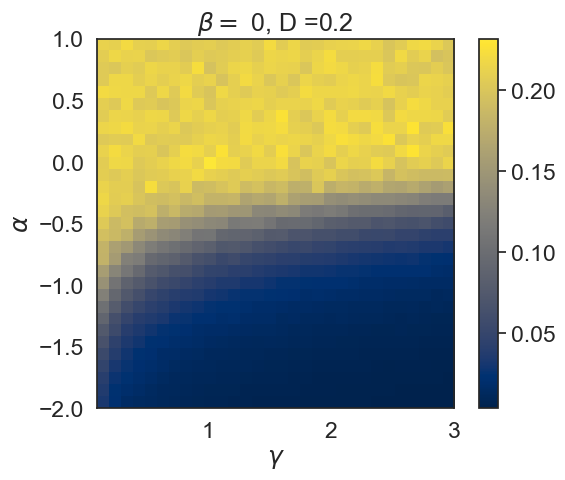

In [8]:
plt.imshow(phdg_cv_alpgam[:,1:], origin='lower', extent=[gamma_ar[1], gamma_ar[-1], alpha_ar[0], alpha_ar[-1]], 
                                                     cmap='cividis')

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\alpha$')

plt.title(r'$\beta =$ {}, D ={}'.format(0, 0.2))

plt.colorbar()
plt.show()

C:\Users\nn\AppData\Local\Temp\ipykernel_20676\313916423.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')


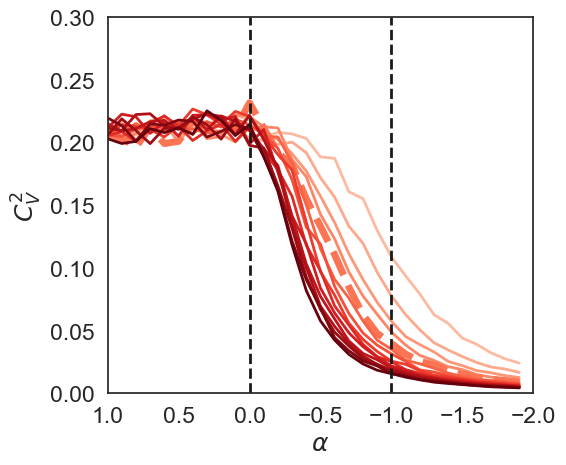

In [9]:
eqdist = 2
gam_ar = np.copy(gamma_ar[::eqdist])

cmap = plt.cm.get_cmap('Reds')
num_lines = 16
line_colors = np.linspace(0.2, 1, num_lines)
rgb_colors_BL = cmap(line_colors)

fig = plt.figure(figsize=(6,5))

for i in np.arange(len(gam_ar)):
    gamma = gam_ar[i]
    if gamma > 3 or gamma<0.1:
        continue
        
    if gamma == 1:
        plt.plot(alpha_ar[1:], phdg_cv_alpgam[1:, i*eqdist], '--', c=rgb_colors_BL[i], label=r'$\gamma =${}'.format(gamma), linewidth=5)
    else:
        plt.plot(alpha_ar[1:], phdg_cv_alpgam[1:, i*eqdist], c=rgb_colors_BL[i], label=r'$\gamma =${}'.format(gamma))
        
plt.vlines(0, 0,.3,linestyle='--', color='k')
plt.vlines(-1, 0, .3,linestyle='--', color='k')



plt.ylabel(r'$C^2_V$')
plt.xlabel(r'$\alpha$')
plt.ylim(ymin=0, ymax=.3)
plt.xlim(xmin=-2,xmax=1)
plt.gca().invert_xaxis()

plt.tight_layout()
#plt.savefig('phasediagram_gamma_cv.pdf')
plt.show()

compare theory CV to measured data

In [11]:
def theory_CVsq(beta):
    
    term1 = - 3 * (-2 + beta) * sp.gamma(-(3/(-2 + beta))) * sp.gamma((-3 + beta)/ (-2 + beta))
    term2 = 4*sp.gamma(-(2/(-2 + beta)))**2
                                                                        
    return -1 + term1/term2 

In [15]:
# save theory CV in array for plotting
RWtheory_plane_arr = np.copy(phdg_cv_alpbet)
RWtheory_plane_arr[:] = np.nan 
for i in np.arange(len(alpha_ar)):
    RWtheory_plane_arr[i,:] = theory_CVsq(np.array(beta_ar))

more theory functions for bessel process

In [22]:
def mean_bessel_theory(alpha, d, t, gamma_val):
    term1 = 2**(1/(-1 + alpha)) * (d*t)**(1/(1 - alpha)) * (1 - alpha)**(-(2/(-1 + alpha)))
    term2 = sp.gamma((3 * d - d * alpha + 2 * gamma_val)/(d - d * alpha))
    term3 = sp.gamma((2 * d - d * alpha + 2 * gamma_val)/(d - d * alpha))
    return term1 * term2 / term3

def var_bessel_theory(alpha, d, t, gamma_val):
    term1 = 4**(1/(-1 + alpha)) * (d * t)**(-(2/(-1 + alpha))) * (1 - alpha)**(-(4/(-1 + alpha)))
    term2 = sp.gamma((3 * d - d * alpha + 2 * gamma_val)/(d - d * alpha))**2
    term3 = sp.gamma((2 * d - d * alpha + 2 * gamma_val)/(d - d * alpha)) * sp.gamma((4 * d - d * alpha + 2 * gamma_val)/(d - d * alpha))
    return term1 * (-term2 + term3) / sp.gamma((2 * d - d * alpha + 2 * gamma_val)/(d - d * alpha))**2

def cv_bessel_theo(alpha, d, t, gamma_val):
    return var_bessel_theory(alpha, d, t, gamma_val)/mean_bessel_theory(alpha, d, t, gamma_val)**2

In [23]:
def cvtheo_1(d, gamma):
    return d/(2*(d+gamma))
    
def cvtheo_05(d, gamma):
    return -1 + sp.gamma(5/3+4*gamma/3/d)*sp.gamma(3+4*gamma/3/d)/sp.gamma(7/3+4*gamma/3/d)**2

def cvtheo_0(d,gamma):
    return -1 + 2*d*sp.gamma(5/2 + gamma/d)**2 / ((3*d+2*gamma)*sp.gamma(2+gamma/d)**2)

def cvtheo_min1(d, gamma):
    return -1 + sp.gamma(2+2*gamma/3/d) * sp.gamma(2/3*(2+gamma/d))/sp.gamma(5/3+2*gamma/3/d)**2 


#### plotting CV phasediagram

C:\Users\nn\AppData\Local\Temp\ipykernel_20676\814442220.py:45: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


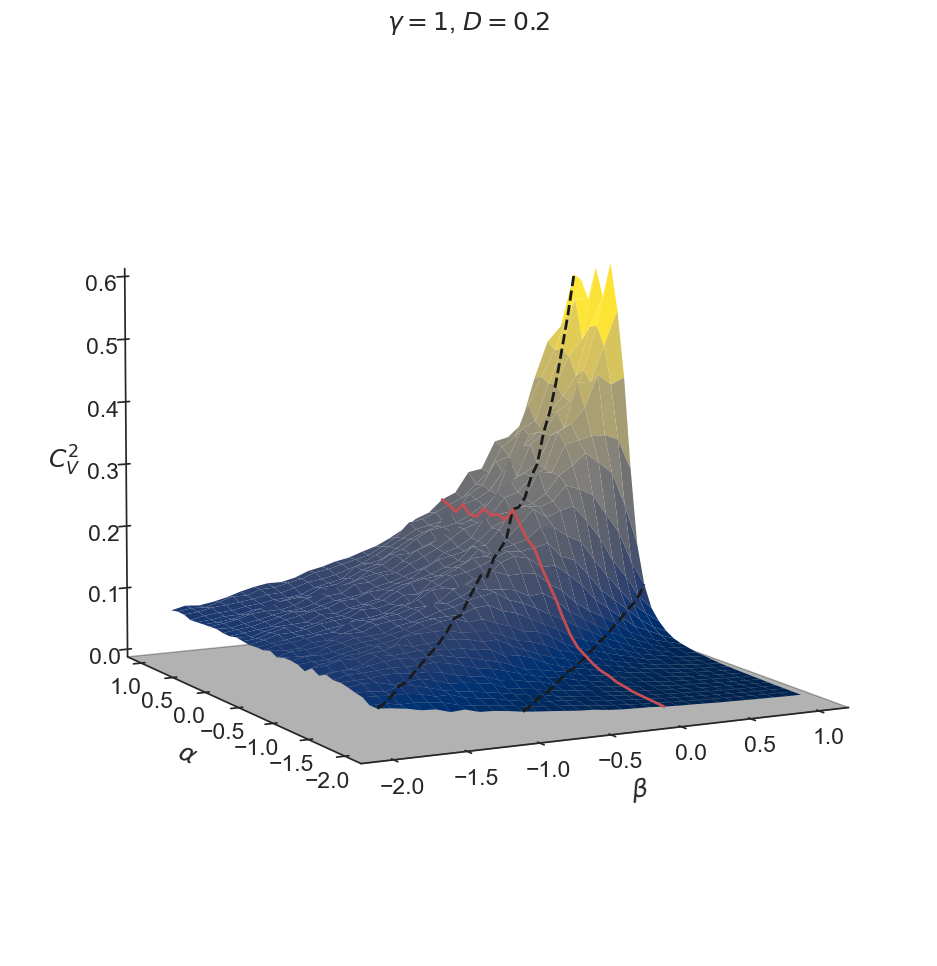

In [16]:
bets = beta_ar[:]
alps = alpha_ar[:]

X,Y = np.meshgrid(bets[:], alps[:])

ph = np.copy(phdg_cv_alpbet[:,:])
Z = ph[:,:]


Z2 = RWtheory_plane_arr

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z,  cmap = 'cividis', linewidth=0, facecolor=None)#,zorder=1)

secondbound= np.diagonal(ph, offset=10)
ax.plot(beta_ar[10:], np.array(alpha_ar[10:])-1, zs=secondbound, linestyle='--' , c='k', alpha=1)
ax.plot(beta_ar, alpha_ar, zs=np.diagonal(ph), linestyle='--', c='k', alpha=1)

ax.plot(np.zeros(len(alpha_ar)),alpha_ar,  ph[:,20], c='r', alpha=1)

ax.set_xlabel(r'$\beta$', labelpad=15)
ax.set_ylabel(r'$\alpha$', labelpad=15)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$C^2_V$', rotation=0, labelpad=10)

ax.view_init(10, 62, -0.3)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.3))

ax.dist = 11

ax.set_zlim(0,.6)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.title(r'$\gamma=1$, $D=0.2$')
plt.tight_layout()

#plt.savefig('phasediagram_cv3D.pdf')

plt.show()

#### theory cv plot

functions for small noise (SN) theory

In [18]:
def mean_tsa_sn_mult(t,gam,d,alpha,beta):
    if alpha <0:
        frac1 = (t*(1 - alpha)*gam)**(1/(1 - alpha))
        nom2 = d*(7*alpha**2 + 2*beta*(1 + beta) - alpha*(3 + 8*beta))*(-t*(-1 + alpha)*gam)**((alpha - beta)/(-1 + alpha))
        denom2 = 2*(2*alpha - beta)*(-1 + 3*alpha - beta)*gam
        frac2 = nom2/denom2
        out = frac1 + frac2
    else:
        out = np.ones(len(t))*np.nan
    return out
    
def var_tsa_sn_mult(t,gam,d,alpha,beta):
    if alpha < 0:
        out = d*(t*(-1 + alpha)*(t*(gam - alpha*gam))**(beta/(1 - alpha)))/(-1 + 3*alpha - beta)
    else:
         out = np.ones(len(t))*np.nan
    return out

In [19]:
tau = 0.01
gamma = 1
D=0.2

SNtheory_plane_arr = np.copy(phdg_cv_alpbet)
SNtheory_plane_arr[:] = np.nan 
for i in np.arange(len(alpha_ar)):
    for j in np.arange(len(beta_ar)):
        
        if alpha_ar[i] > beta_ar[j] -0.9:
            continue
        
        try:
            cvs = var_tsa_sn_mult(tau,gamma,D,alpha_ar[i],beta_ar[j])/mean_tsa_sn_mult(tau,gamma,D,alpha_ar[i],beta_ar[j])**2
        
            SNtheory_plane_arr[i,j] = cvs
        except:
            SNtheory_plane_arr[i,j] = np.nan
        
        

In [20]:
RWtheory_plane_arr = np.copy(phdg_cv_alpbet)
RWtheory_plane_arr[:] = np.nan 
for i in np.arange(len(alpha_ar)):
    RWtheory_plane_arr[i,:] = theory_CVsq(np.array(beta_ar))
    
for i in np.arange(len(alpha_ar)):  
    for j in np.arange(len(beta_ar)):
        if alpha_ar[i] < beta_ar[j]:
            RWtheory_plane_arr[i,j] = np.nan

C:\Users\nn\AppData\Local\Temp\ipykernel_20676\2835373836.py:46: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


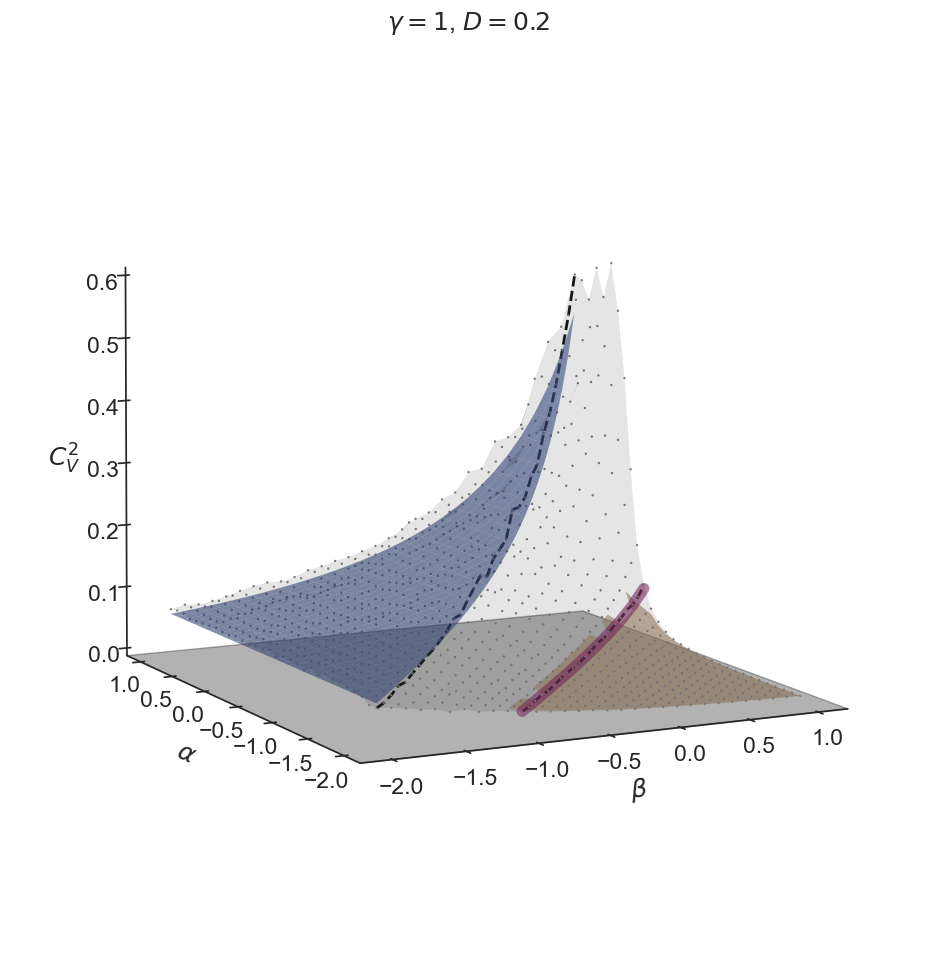

In [24]:
bets = beta_ar[:]
alps = alpha_ar[:]

X,Y = np.meshgrid(bets[:], alps[:])

ph = np.copy(phdg_cv_alpbet[:,:])
Z = ph[:,:]


Z2 = RWtheory_plane_arr
Z3 = SNtheory_plane_arr

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z2,  color = (63/255,86/255,147/255, 0.6), linewidth=0.0, vmin=0.01, vmax=0.02)#,zorder=2)cmap = 'Greys', alpha=0.4
ax.plot_surface(X, Y, Z3,  color = (210/255,172/255,132/255, 0.6), linewidth=0.0)#, vmin=0.01, vmax=0.02)#,zorder=2)cmap = 'Greys', alpha=0.4

ax.scatter(X.flatten(), Y.flatten(), zs=ph.flatten() , c='gray', alpha=1, s=1/2)
ax.plot_surface(X, Y, ph,  color = (0,0,0, 0.1), linewidth=0.0)#, vmin=0.01, vmax=0.02)#,zorder=2)cmap = 'Greys', alpha=0.4


secondbound= np.diagonal(ph, offset=10)

###boundaries
secondbound= np.diagonal(ph, offset=10)
ax.plot(beta_ar[10:], np.array(alpha_ar[10:])-1, zs=secondbound, linestyle='--' , c='k', alpha=1)
ax.plot(beta_ar, alpha_ar, zs=np.diagonal(ph), linestyle='--', c='k', alpha=1)

    
alphabess = np.arange(-2, 0.2, 0.2)    
plt.plot(alphabess+1, alphabess, cv_bessel_theo(alphabess, 0.2, 0.01, 1), c=(132/255,45/255,100/255), alpha=0.6, linewidth=8)


ax.set_xlabel(r'$\beta$', labelpad=15)
ax.set_ylabel(r'$\alpha$', labelpad=15)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$C^2_V$', rotation=0, labelpad=10)

ax.view_init(10, 62,-0.5)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.3))

ax.dist = 11

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

ax.set_zlim(0,.6)

plt.title(r'$\gamma=1$, $D=0.2$')
plt.tight_layout()

#plt.savefig('phasediagram_cv3D_theory.pdf')

plt.show()

### plotting examples of 4 cases

[1, 1]
[1, 0]
[-1, 0]


C:\Users\nn\AppData\Local\Temp\ipykernel_20676\1835872771.py:31: RuntimeWarning: invalid value encountered in divide
  cv = var/mean**2
C:\Users\nn\AppData\Local\Temp\ipykernel_20676\1835872771.py:39: RuntimeWarning: invalid value encountered in divide
  cvrw = varrw/meanrw**2


[0, 1]


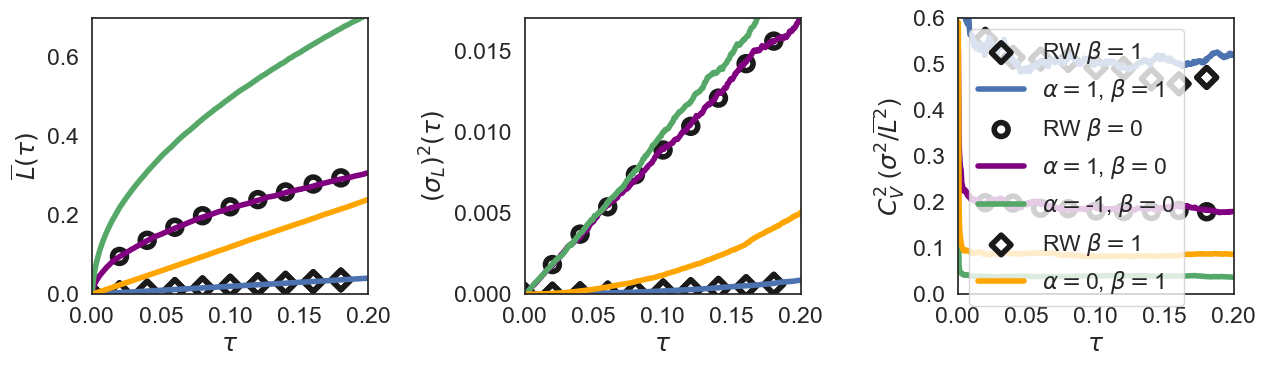

In [28]:
path_data = ""

cases = [[1, 1],
         [1, 0],
         [-1,0],
        [0,1]]


### want covariance to be 100x100
dt = 0.0005
t_analyze = 0.2
Ntimesteps = int(t_analyze/dt)
spacing = int(Ntimesteps/100)

t = np.linspace(0,t_analyze, Ntimesteps)

gamma = 1
D=0.2
nrealiz=2000

fig, ax = plt.subplots(1,3, figsize=(13,4))

countrw = 0
for case in cases:
    print(case)
    alpha, beta = case

    mean = np.loadtxt(os.path.join(path_data, "mean_gamma{}_D{}_alpha{}_beta{}_N{}_dt{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz, int(dt*10))), delimiter=",")
    var = np.loadtxt(os.path.join(path_data, "var_gamma{}_D{}_alpha{}_beta{}_N{}_dt{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz, int(dt*10))), delimiter=",")
    cv = var/mean**2
    
    meanrw = np.loadtxt(os.path.join(path_data, "mean_gamma{}_D{}_alpha{}_beta{}_N{}_dt{}.txt".format(int(0*10),int(D*10), int(0*10), int(beta*10), nrealiz, int(dt*10))), delimiter=",")
    varrw = np.loadtxt(os.path.join(path_data, "var_gamma{}_D{}_alpha{}_beta{}_N{}_dt{}.txt".format(int(0*10),int(D*10), int(0*10), int(beta*10), nrealiz, int(dt*10))), delimiter=",")
    cvrw = varrw/meanrw**2
    
    equidist = 40
    dotsize = 100
    
    if beta ==0:
        if countrw ==0:
            countrw +=1
            ax[0].scatter(t[::equidist],meanrw[:Ntimesteps][::equidist], s=dotsize, color='k', marker='o', facecolors='none', linewidth=4)#, origin='lower', cmap='RdBu_r', vmin = minval, vmax=maxval,extent=[0.0, 0.2, 0.0, 0.2])
            #ax[0].set_title(case)
            ax[1].scatter(t[::equidist],varrw[:Ntimesteps][::equidist], s=dotsize, marker='o', facecolors='none', color='k', linewidth=4)#, origin='lower', cmap='RdBu_r', vmin = minval, vmax=maxval,extent=[0.0, 0.2, 0.0, 0.2])
            ax[2].scatter(t[::equidist],cvrw[:Ntimesteps][::equidist], s=dotsize, marker='o', facecolors='none', color='k', linewidth=4, label=r'RW $\beta=${}'.format(beta))#, origin='lower', cmap='RdBu_r', vmin = minval, vmax=maxval,extent=[0.0, 0.2, 0.0, 0.2])
    elif beta == 1:
        ax[0].scatter(t[::equidist],meanrw[:Ntimesteps][::equidist], s=dotsize, marker='D', facecolors='none', color='k', linewidth=4)#, origin='lower', cmap='RdBu_r', vmin = minval, vmax=maxval,extent=[0.0, 0.2, 0.0, 0.2])
        #ax[0].set_title(case)
        ax[1].scatter(t[::equidist],varrw[:Ntimesteps][::equidist], s=dotsize, marker='D', facecolors='none', color='k', linewidth=4)#, origin='lower', cmap='RdBu_r', vmin = minval, vmax=maxval,extent=[0.0, 0.2, 0.0, 0.2])
        ax[2].scatter(t[::equidist],cvrw[:Ntimesteps][::equidist], s=dotsize, marker='D', facecolors='none', color='k', linewidth=4, label=r'RW $\beta=${}'.format(beta))#, origin='lower', cmap='RdBu_r', vmin = minval, vmax=maxval,extent=[0.0, 0.2, 0.0, 0.2])
    
    
    if case == [1,1]:
        col = 'b'
    elif case == [1,0]:
        col = 'purple'
    elif case == [0,1]:
        col = 'orange'
    elif case == [-1,0]:
        col = 'g'
    ax[0].plot(t,mean[:Ntimesteps], color=col, linewidth=4)
    ax[1].plot(t,var[:Ntimesteps], color=col, linewidth=4)
    ax[2].plot(t,cv[:Ntimesteps], color=col, linewidth=4, label=r'$\alpha=${}, $\beta=${}'.format(alpha, beta))#, origin='lower', cmap='RdBu_r', vmin = minval, vmax=maxval,extent=[0.0, 0.2, 0.0, 0.2])
    
    
ax[0].set_xlabel(r'$\tau$')
ax[0].set_ylabel(r'$\overline{L}(\tau)$')
#ax[0].locator_params(tight=True,nbins=2)
ax[1].set_xlabel(r'$\tau $')
ax[1].set_ylabel(r'$(\sigma_L)^2(\tau)$')
#ax[1].locator_params(tight=True,nbins=2)
ax[2].set_xlabel(r'$\tau $')
ax[2].set_ylabel(r'$C^2_V$ ($\sigma^2 / \overline{L}^2$)')

ax[0].set_ylim(0, 0.7)
ax[1].set_ylim(0, 0.017)
ax[2].set_ylim(0, 0.6)
ax[0].set_xlim(0, 0.2)
ax[1].set_xlim(0, 0.2)
ax[2].set_xlim(0, 0.2)

plt.legend()

plt.tight_layout()

#plt.savefig('example_meanvarcv.pdf')

plt.show()
